# Импорт библиотек

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
import kagglehub

# Загрузка данных

In [ ]:
path = kagglehub.dataset_download("yaaryiitturan/auto-scout-car-price")
os.listdir(path)

['final_scout_not_dummy.csv']

In [ ]:
data = pd.read_csv(path + '/final_scout_not_dummy.csv')
data.head()

,make_model,body_type,price,vat,km,Type,Fuel,Gears,Comfort_Convenience,Entertainment_Media,...,Previous_Owners,hp_kW,Inspection_new,Paint_Type,Upholstery_type,Gearing_Type,Displacement_cc,Weight_kg,Drive_chain,cons_comb
0,Audi A1,Sedans,15770,VAT deductible,56013.0,Used,Diesel,7.0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...",...,2.0,66.0,1,Metallic,Cloth,Automatic,1422.0,1220.0,front,3.8
1,Audi A1,Sedans,14500,Price negotiable,80000.0,Used,Benzine,7.0,"Air conditioning,Automatic climate control,Hil...","Bluetooth,Hands-free equipment,On-board comput...",...,1.0,141.0,0,Metallic,Cloth,Automatic,1798.0,1255.0,front,5.6
2,Audi A1,Sedans,14640,VAT deductible,83450.0,Used,Diesel,7.0,"Air conditioning,Cruise control,Electrical sid...","MP3,On-board computer",...,1.0,85.0,0,Metallic,Cloth,Automatic,1598.0,1135.0,front,3.8
3,Audi A1,Sedans,14500,VAT deductible,73000.0,Used,Diesel,6.0,"Air suspension,Armrest,Auxiliary heating,Elect...","Bluetooth,CD player,Hands-free equipment,MP3,O...",...,1.0,66.0,0,Metallic,Cloth,Automatic,1422.0,1195.0,front,3.8
4,Audi A1,Sedans,16790,VAT deductible,16200.0,Used,Diesel,7.0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,MP3,O...",...,1.0,66.0,1,Metallic,Cloth,Automatic,1422.0,1135.0,front,4.1


# Предобработка данных

In [ ]:
data_preprocessed = data.copy()

## 1. One-hot-encoding для категориальных данных

In [ ]:
categorical_columns = ['make_model', 'body_type', 'Fuel', 'Gearing_Type', 'Paint_Type', 'Drive_chain', 'vat', 'Type', 'Upholstery_type']
data_preprocessed = pd.get_dummies(data_preprocessed, columns=categorical_columns, drop_first=True)

## 2. Извлечение количества опций из текстовых колонок

In [ ]:
option_columns = ['Comfort_Convenience', 'Entertainment_Media', 'Extras', 'Safety_Security']
for col in option_columns:
    data_preprocessed[col + '_count'] = data_preprocessed[col].apply(lambda x: len(str(x).split(',')))
data_preprocessed.drop(columns=option_columns, inplace=True)

## 3. Нормализация числовых данных

In [ ]:
numeric_columns = ['km', 'age', 'hp_kW', 'Displacement_cc', 'Weight_kg', 'cons_comb', 'Previous_Owners']
scaler = MinMaxScaler()
data_preprocessed[numeric_columns] = scaler.fit_transform(data_preprocessed[numeric_columns])

# Исследовательский анализ данных

## 1. Анализ распределения целевой переменной

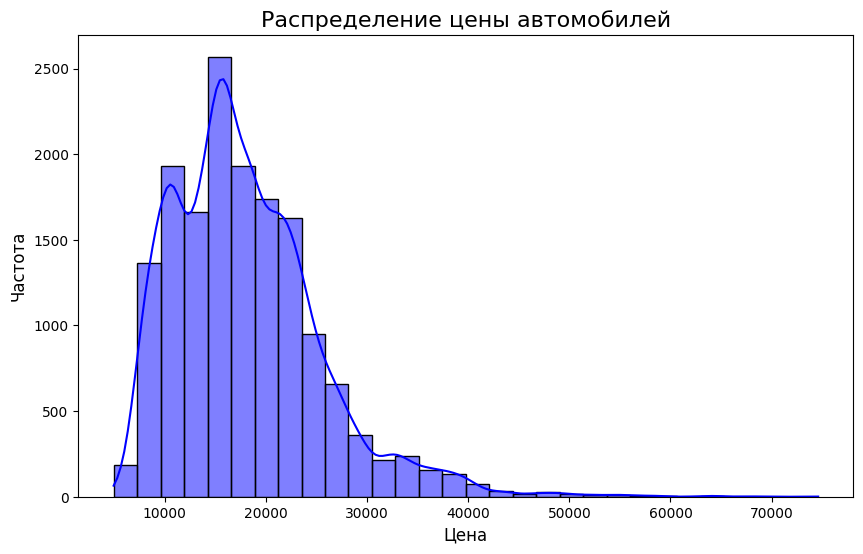

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data_preprocessed['price'], kde=True, bins=30, color='blue')
plt.title('Распределение цены автомобилей', fontsize=16)
plt.xlabel('Цена', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.show()

## 2. Корреляционный анализ

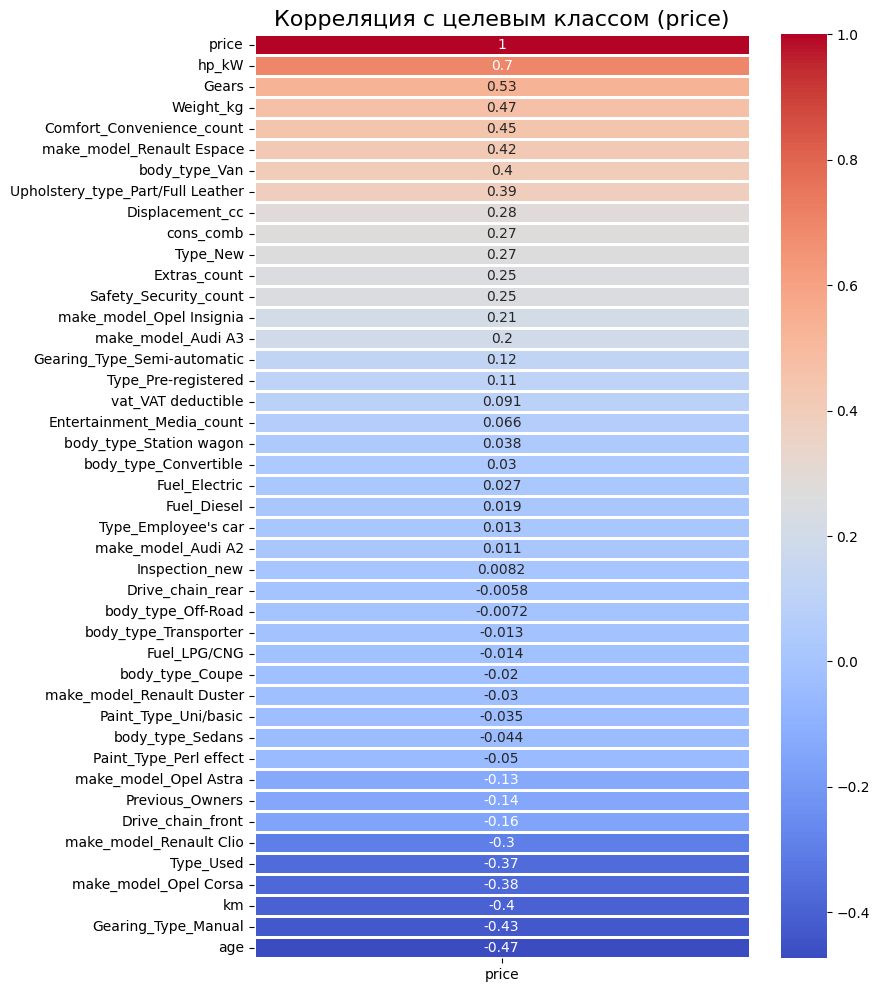

In [ ]:
corr_with_target = data_preprocessed.corr()['price'].sort_values(ascending=False)

plt.figure(figsize=(8, 12))
sns.heatmap(corr_with_target.to_frame(), cmap='coolwarm', annot=True, cbar=True, linewidths=1)
plt.title('Корреляция с целевым классом (price)', fontsize=16)
plt.show()

In [ ]:
# Отбираем столбцы, у которых корреляция по модулю меньше 0.1
columns_to_drop = corr_with_target[abs(corr_with_target) < 0.1].index.tolist()

# Удаляем эти столбцы из DataFrame
data_preprocessed = data_preprocessed.drop(columns=columns_to_drop)

## 3. Оценка влияния основных признаков на цену

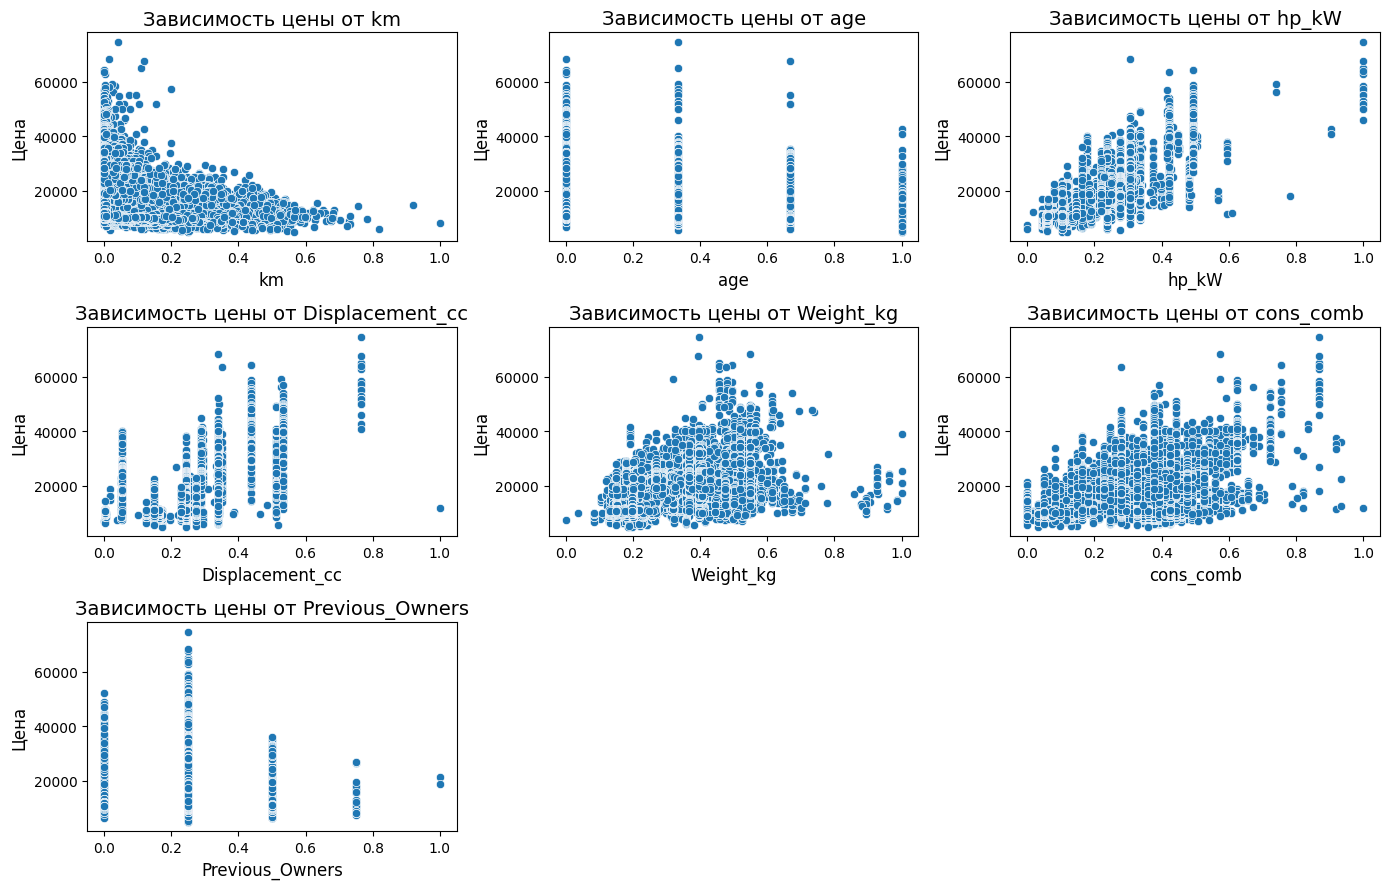

In [ ]:
numeric_features = ['km', 'age', 'hp_kW', 'Displacement_cc', 'Weight_kg', 'cons_comb', 'Previous_Owners']

# Определяем количество строк и столбцов
n_cols = 3
n_rows = (len(numeric_features) + n_cols - 1) // n_cols  # Вычисляем необходимое количество строк

# Создаем фигуру и оси
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows))
axes = axes.flatten()  # Преобразуем массив осей в плоский список для удобства

# Рисуем графики
for i, feature in enumerate(numeric_features):
    sns.scatterplot(ax=axes[i], x=data_preprocessed[feature], y=data_preprocessed['price'])
    axes[i].set_title(f'Зависимость цены от {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Цена', fontsize=12)

# Удаляем пустые графики, если есть
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Обучение моделей

In [ ]:
# Вспомогательная функция для подсчета и вывода метрик полученный моделей
def printModelScores(model, modelName, y_pred, best_params=None):
  print(f"{modelName}:")
  if best_params is not None: print(f"Лучшие гиперпараметры: {best_params}")
  print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
  print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
  print(f"R2: {r2_score(y_test, y_pred):.2f}\n")

## Разделение данных на обучающую и тестовую выборки

In [ ]:
X = data_preprocessed.drop(columns=['price'])
y = data_preprocessed['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. Линейная регрессия

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Метрики для линейной регрессии
printModelScores(lr_model, 'Линейная регрессия', y_pred_lr)

Линейная регрессия:
MAE: 1930.41
MSE: 7400475.21
R2: 0.86



## 2. Градиентный бустинг

In [ ]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Поиск гиперпараметров с GridSearchCV
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train, y_train)
best_gb_model = gb_grid_search.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)

# Метрики для градиентного бустинга
printModelScores(gb_model, 'Градиентный бустинг', y_pred_gb, gb_grid_search.best_params_)

Градиентный бустинг:
Лучшие гиперпараметры: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}
MAE: 1021.04
MSE: 2617996.69
R2: 0.95



## 3. Случайный лес

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Поиск гиперпараметров с GridSearchCV
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Метрики для случайного леса
printModelScores(rf_model, 'Случайный лес бустинг', y_pred_rf, rf_grid_search.best_params_)

Случайный лес бустинг:
Лучшие гиперпараметры: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 937.43
MSE: 2680731.87
R2: 0.95



## 4. K-ближайшие соседи с GridSearchCV

In [ ]:
knn_model = KNeighborsRegressor()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Поиск гиперпараметров с GridSearchCV
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
knn_grid_search.fit(X_train, y_train)
best_knn_model = knn_grid_search.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)

# Метрики для K-ближайших соседей
printModelScores(rf_model, 'K-ближайшие соседи', y_pred_knn, knn_grid_search.best_params_)

K-ближайшие соседи:
Лучшие гиперпараметры: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
MAE: 1605.11
MSE: 8373830.78
R2: 0.84



# Визуализация качества моделей

## 1. Линейная регрессия

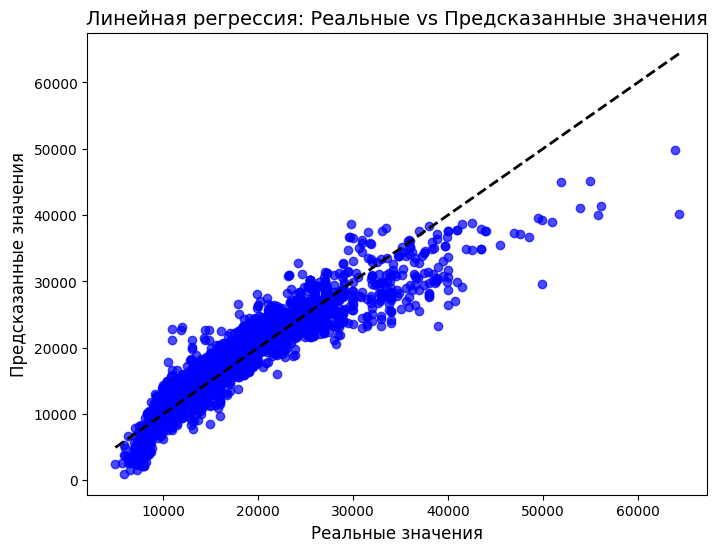

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Линейная регрессия: Реальные vs Предсказанные значения', fontsize=14)
plt.xlabel('Реальные значения', fontsize=12)
plt.ylabel('Предсказанные значения', fontsize=12)
plt.show()

## 2. Градиентный бустинг

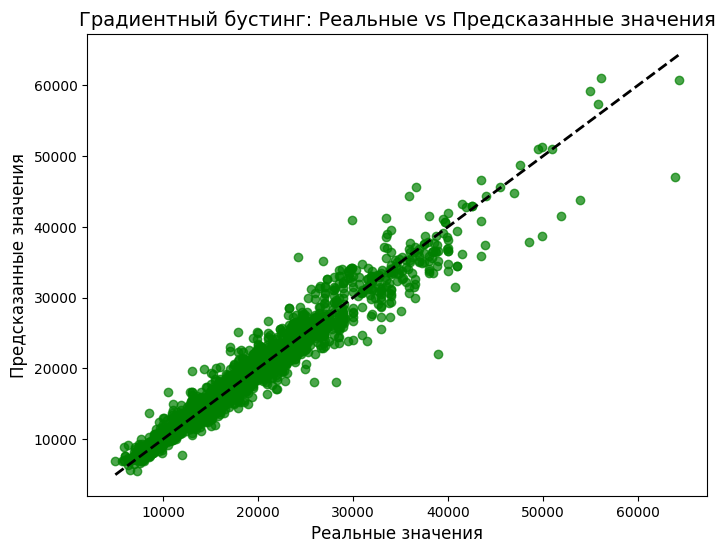

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Градиентный бустинг: Реальные vs Предсказанные значения', fontsize=14)
plt.xlabel('Реальные значения', fontsize=12)
plt.ylabel('Предсказанные значения', fontsize=12)
plt.show()

## 3. Случайный лес

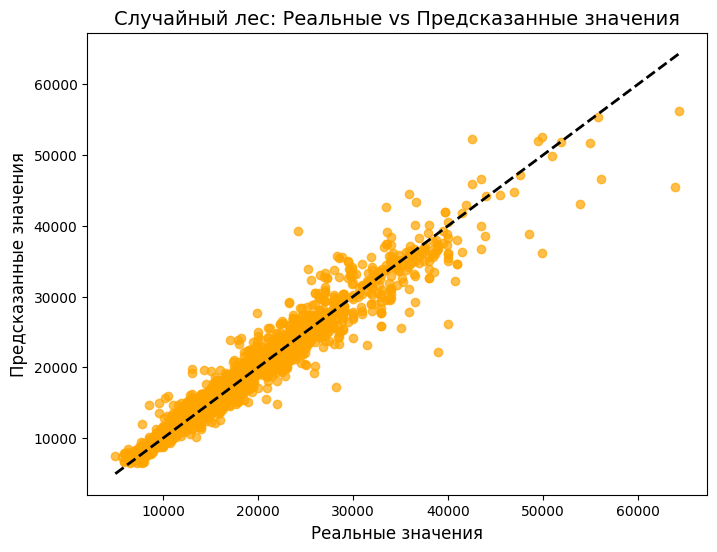

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Случайный лес: Реальные vs Предсказанные значения', fontsize=14)
plt.xlabel('Реальные значения', fontsize=12)
plt.ylabel('Предсказанные значения', fontsize=12)
plt.show()

## 4. K-ближайшие соседи

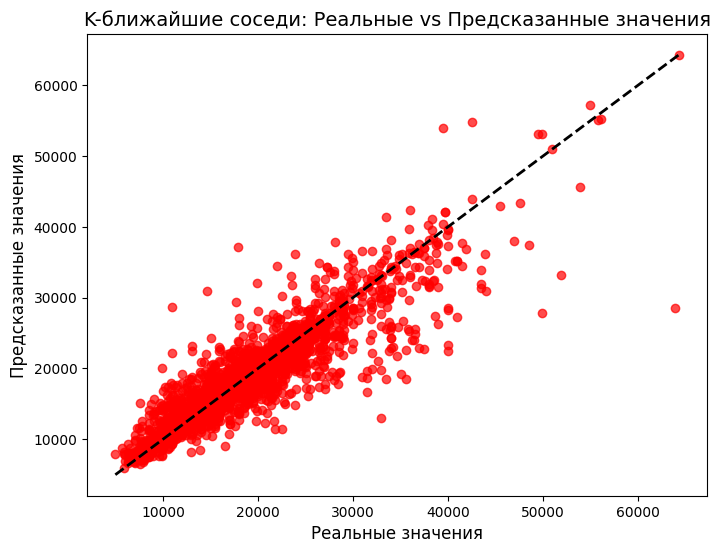

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.7, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('K-ближайшие соседи: Реальные vs Предсказанные значения', fontsize=14)
plt.xlabel('Реальные значения', fontsize=12)
plt.ylabel('Предсказанные значения', fontsize=12)
plt.show()

# Выводы

Градиентный бустинг показывает лучшие метрики (MAE, MSE, R²) и меньший разброс на графике.
Линейная регрессия хороша, но уступает градиентному бустингу в точности.
Случайный лес близок по качеству к градиентному бустингу, но чуть менее стабилен.
K-ближайшие соседи имеют худшие метрики и показывают большую вариабельность в предсказаниях.